In [84]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import time
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV

In [4]:
## this function is from Prof. Chugg's torch_fmnist_loader notebook
## https://github.com/keithchugg/ee559_spring2023/blob/main/hw_helpers/torch_fmnist_loader.py

class FashionMNISTDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, index):
        image, label = self.data[index]
        return image, label

    def __len__(self):
        return len(self.data)

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),]) 
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)

In [5]:
trainset, valset = torch.utils.data.random_split(trainset, [48000, 12000])
print(f'Train set size: {len(trainset)}, Validation set size: {len(valset)}, Test set size: {len(testset)}')

Train set size: 48000, Validation set size: 12000, Test set size: 10000


# ANN/MLP Model Definition

Start with 𝑀=48 hidden nodes,𝜂 = 0.01, 𝜆 = 10^-3 and 𝐵 = 32

In [157]:
## this function is from Prof. Chugg's fmnist_mlp_torch notebook
## https://github.com/keithchugg/ee559_spring2023/blob/main/hw_helpers/fmnist_mlp_torch.py

# Parameters for the model
n_pixels = 28 * 28
n_classes = 10
n_hidden = 48

# Define the model
class MLP(nn.Module):
    def __init__(self, n_hidden): # Define layers in the constructor
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, n_hidden)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden, 10)
        
    def forward(self, x): # Define forward pass in the forward method
        x = x.view(x.shape[0], -1)  #flatten into a 784 length tensor
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x # note: no softmax, as this is included in the loss function in PyTorch

# Train Model

In [199]:
## this function is from Prof. Chugg's fmnist_mlp_torch notebook
## https://github.com/keithchugg/ee559_spring2023/blob/main/hw_helpers/fmnist_mlp_torch.py

# Define function to call for each training epoch (one complete pass over the training set)
def train(model, trainloader, criterion, optimizer, device):
    model.train() # set model to training mode
    running_loss = 0; running_acc = 0
#     with tqdm(total=len(trainloader), desc=f"Train", unit="batch") as pbar:
#         for n_batch, (images, labels) in enumerate(trainloader): # Iterate over batches
#             images, labels = images.to(device), labels.to(device) # Move batch to device
#             optimizer.zero_grad()
#             output = model(images) # Forward pass
#             loss = criterion(output, labels) # Compute loss
#             loss.backward() # Backward pass
#             optimizer.step() # Update weights
#             running_loss += loss.item()
#             running_acc += (output.argmax(1) == labels).float().mean().item()
#             pbar.set_postfix({'loss': loss.item(), 'acc': 100. * running_acc / (n_batch+1)})
#             pbar.update() # Update progress bar
    for n_batch, (images, labels) in enumerate(trainloader): # Iterate over batches
            images, labels = images.to(device), labels.to(device) # Move batch to device
            optimizer.zero_grad()
            output = model(images) # Forward pass
            loss = criterion(output, labels) # Compute loss
            loss.backward() # Backward pass
            optimizer.step() # Update weights
            running_loss += loss.item()
            running_acc += (output.argmax(1) == labels).float().mean().item()
    return running_loss / len(trainloader), running_acc / len(trainloader) # return loss and accuracy for this epoch

In [200]:
## this function is from Prof. Chugg's fmnist_mlp_torch notebook
## https://github.com/keithchugg/ee559_spring2023/blob/main/hw_helpers/fmnist_mlp_torch.py

# Define function to call for each validation epoch (one complete pass over the validation set)
def validate(model, valloader, criterion, device):
    model.eval() # set model to evaluation mode (e.g. turn off dropout, batchnorm, etc.)
    running_loss = 0; running_acc = 0
    with torch.no_grad(): # no need to compute gradients for validation
#         with tqdm(total=len(valloader), desc=f"Eval", unit="batch") as pbar:
#             for n_batch, (images, labels) in enumerate(valloader): # Iterate over batches
#                 images, labels = images.to(device), labels.to(device) # Move batch to device
#                 output = model(images) # Forward pass
#                 loss = criterion(output, labels) # Compute loss
#                 running_loss += loss.item() 
#                 running_acc += (output.argmax(1) == labels).float().mean().item()
#                 pbar.set_postfix({'loss': loss.item(), 'acc': 100. * running_acc / (n_batch+1)})
#                 pbar.update() # Update progress bar
        for n_batch, (images, labels) in enumerate(valloader): # Iterate over batches
            images, labels = images.to(device), labels.to(device) # Move batch to device
            output = model(images) # Forward pass
            loss = criterion(output, labels) # Compute loss
            running_loss += loss.item() 
            running_acc += (output.argmax(1) == labels).float().mean().item()

    return running_loss / len(valloader), running_acc / len(valloader)  # return loss and accuracy for this epoch

In [173]:
def report_runtime(batchsize):
    
    runtime_history = []
    # Create a model
    model = MLP(n_hidden)
#         print(model)

    lr = 0.01   ## the learning rate in TF is part of the optimizer.  Default is 1e-2
    reg_val = 1e-3
    criterion = nn.CrossEntropyLoss() # includes softmax (for numerical stability)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=reg_val)
    device = torch.device("cpu")
#         print(f'Using device: {device}')
    model.to(device) # Move model to device
    
    ite = 0
    for ite in range(5): # Run 5 times
        val_acc_checkpoint = -1
        epoch = 0
        # Shuffle the data at the start of each epoch (only useful for training set)
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=True)
        valloader = torch.utils.data.DataLoader(valset, batch_size=batchsize, shuffle=False)
        testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize, shuffle=False)
        
        start = time.time()
        while(val_acc_checkpoint <= 0.8):
            print(f"Epoch {epoch+1} in time {ite+1}")
            train_loss, train_acc  = train(model, trainloader, criterion, optimizer, device) # Train
            val_loss, val_acc = validate(model, valloader, criterion, device) # Validate
            val_acc_checkpoint = val_acc
#             train_loss_history.append(train_loss)
#             train_acc_history.append(train_acc)
#             val_loss_history.append(val_loss)
#             val_acc_history.append(val_acc)
            epoch += 1
    
        end = time.time()
        runtime = end - start
        runtime_history.append(runtime)
    print(f'The batch size is {batchsize}, and the mean is {np.mean(runtime_history)}, the std is {np.std(runtime_history)}')


In [176]:
report_runtime(32)

Epoch 1 in time 1


Eval: 100%|█████████| 375/375 [00:02<00:00, 183.02batch/s, loss=0.611, acc=81.4]


Epoch 1 in time 2


Eval: 100%|██████████| 375/375 [00:02<00:00, 179.11batch/s, loss=0.46, acc=83.2]


Epoch 1 in time 3


Eval: 100%|█████████| 375/375 [00:02<00:00, 187.26batch/s, loss=0.494, acc=83.9]


Epoch 1 in time 4


Eval: 100%|█████████| 375/375 [00:02<00:00, 183.65batch/s, loss=0.546, acc=84.3]


Epoch 1 in time 5


Eval: 100%|█████████| 375/375 [00:01<00:00, 189.47batch/s, loss=0.487, acc=85.4]

The batch size is 32, and the mean is 12.781783056259155, the std is 0.15533816985575313


In [177]:
report_runtime(16)

Epoch 1 in time 1


Eval: 100%|█████████| 750/750 [00:02<00:00, 278.11batch/s, loss=0.684, acc=82.1]


Epoch 1 in time 2


Eval: 100%|█████████| 750/750 [00:02<00:00, 282.17batch/s, loss=0.557, acc=83.9]


Epoch 1 in time 3


Eval: 100%|█████████| 750/750 [00:02<00:00, 280.37batch/s, loss=0.621, acc=84.7]


Epoch 1 in time 4


Eval: 100%|███████████| 750/750 [00:02<00:00, 278.45batch/s, loss=0.745, acc=86]


Epoch 1 in time 5


Eval: 100%|███████████| 750/750 [00:02<00:00, 279.10batch/s, loss=0.648, acc=86]

The batch size is 16, and the mean is 18.344105577468873, the std is 0.34812015279238673


In [174]:
report_runtime(64)

Epoch 1 in time 1


Eval: 100%|█████████| 188/188 [00:01<00:00, 120.15batch/s, loss=0.714, acc=78.7]


Epoch 2 in time 1


Eval: 100%|█████████| 188/188 [00:01<00:00, 119.93batch/s, loss=0.579, acc=81.4]


Epoch 1 in time 2


Eval: 100%|█████████| 188/188 [00:01<00:00, 117.27batch/s, loss=0.495, acc=82.7]


Epoch 1 in time 3


Eval: 100%|█████████| 188/188 [00:01<00:00, 120.18batch/s, loss=0.514, acc=83.3]


Epoch 1 in time 4


Eval: 100%|█████████| 188/188 [00:01<00:00, 119.63batch/s, loss=0.485, acc=83.8]


Epoch 1 in time 5


Eval: 100%|██████████| 188/188 [00:01<00:00, 118.31batch/s, loss=0.42, acc=84.4]

The batch size is 64, and the mean is 10.510799455642701, the std is 3.460327396677144


In [175]:
report_runtime(128)

Epoch 1 in time 1


Eval: 100%|████████████| 94/94 [00:01<00:00, 69.22batch/s, loss=0.816, acc=75.4]


Epoch 2 in time 1


Eval: 100%|████████████| 94/94 [00:01<00:00, 67.08batch/s, loss=0.691, acc=78.4]


Epoch 3 in time 1


Eval: 100%|█████████████| 94/94 [00:01<00:00, 69.30batch/s, loss=0.63, acc=80.3]


Epoch 1 in time 2


Eval: 100%|████████████| 94/94 [00:01<00:00, 68.80batch/s, loss=0.591, acc=81.3]


Epoch 1 in time 3


Eval: 100%|████████████| 94/94 [00:01<00:00, 67.95batch/s, loss=0.558, acc=82.3]


Epoch 1 in time 4


Eval: 100%|████████████| 94/94 [00:01<00:00, 67.02batch/s, loss=0.538, acc=82.7]


Epoch 1 in time 5


Eval: 100%|████████████| 94/94 [00:01<00:00, 64.57batch/s, loss=0.504, acc=83.1]

The batch size is 128, and the mean is 10.795682621002197, the std is 6.1475982896351065


## Using batchsize = 64 according to the result above

In [158]:
def grid_search():
    # create model with skorch
    model = NeuralNetClassifier(
        MLP,
        criterion=nn.CrossEntropyLoss,
        optimizer=optim.SGD,
        max_epochs=30,
        batch_size=64,
        lr=1e-02,
        iterator_train__shuffle=True
    )
    # define the grid search parameters
    param_grid = {
        'optimizer__lr': [0.001, 0.01, 0.1],
        'optimizer__weight_decay': [1e-04, 1e-03, 1e-02],
        'module__n_hidden': [40, 80, 160]
    }
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, scoring='accuracy',return_train_score = True)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=False)
    
    X_train = np.array([X_train.cpu().detach().numpy() for X_train, y_train in trainloader])
    X_train = np.squeeze(np.concatenate(X_train, axis=0))
    y_train = np.array([y_train.cpu().detach().numpy() for X_train, y_train in trainloader])
    y_train = np.squeeze(np.concatenate(y_train, axis=0))
    grid_result = grid.fit(X_train,y_train) 
    
    return grid_result

In [143]:
grid_result = grid_search()

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.5381       0.7053        1.0495  1.3321
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.4536       0.7103        1.0052  1.3613
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7201       0.8050        0.5398  1.3827
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.4985       0.7120        1.0097  1.4039
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.5301       0.7048        1.0365  1.4641
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.4608       0.7

      9        0.5205       0.8219        0.5135  1.3101
     10        0.5158       0.8216        0.5106  1.1247
     10        0.5340       0.8166        0.5306  1.2169
     10        0.5148       0.8127        0.5278  1.1626
     10        0.5265       0.8095        0.5396  1.1794
     10        0.5050       0.8283        0.5000  1.2635
     10        0.5269       0.8220        0.5200  1.2149
     10        0.5053       0.8253        0.5029  1.1551
     10        0.5039       0.8180        0.5203  1.2260
     10        0.3514       0.8630        0.3964  1.1815
     10        0.5083       0.8211        0.5053  1.2041
     11        0.5059       0.8211        0.5006  1.1249
     11        0.5241       0.8228        0.5191  1.0609
     11        0.5036       0.8158        0.5192  1.1588
     11        0.5165       0.8150        0.5306  1.1391
     11        0.5169       0.8241        0.5116  1.1093
     11        0.4949       0.8286        0.4913  1.1159
     11        0.4932       0.8

     20        0.4524       0.8423        0.4539  1.1494
     20        0.4744       0.8375        0.4738  1.1715
     20        0.4667       0.8375        0.4705  1.1063
     20        0.4687       0.8295        0.4888  1.1522
     20        0.4441       0.8350        0.4692  1.1083
     20        0.4425       0.8472        0.4494  1.0745
     20        0.2899       0.8647        0.3828  1.1004
     20        0.4378       0.8375        0.4620  1.1820
     20        0.4439       0.8406        0.4449  1.0973
     20        0.4428       0.8444        0.4488  1.1351
     21        0.4487       0.8427        0.4507  1.0884
     21        0.4711       0.8414        0.4715  1.1069
     21        0.4636       0.8433        0.4655  1.1352
     21        0.4655       0.8270        0.4890  1.1319
     21        0.4387       0.8455        0.4475  1.0894
     21        0.4398       0.8328        0.4692  1.1205
     21        0.4339       0.8377        0.4591  1.1460
     21        0.2849       0.8

     30        0.2479       0.8681        0.3829  1.0960
     30        0.4113       0.8506        0.4216  1.1162
     30        0.4057       0.8430        0.4377  1.2076
     30        0.4123       0.8500        0.4256  1.2912
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7189       0.8114        0.5257  1.2964
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7280       0.8047        0.5345  1.3101
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7231       0.8078        0.5362  1.2333
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7394       0.8061        0.5344  1.1445
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  --------

      9        0.4215       0.8478        0.4314  1.0931
      9        0.3290       0.8073        0.5926  1.1086
      9        0.3653       0.8589        0.3841  1.1371
      9        0.3286       0.8708        0.3642  1.1136
     10        0.3479       0.8662        0.3813  1.1246
     10        0.3568       0.8611        0.3841  1.1998
     10        0.3532       0.8669        0.3745  1.1864
     10        0.4132       0.8530        0.4220  1.1411
     10        0.3558       0.8605        0.4036  1.1564
     10        0.4196       0.8423        0.4432  1.1635
     10        0.4181       0.8517        0.4253  1.1328
     10        0.3205       0.8534        0.4322  1.1018
     10        0.3571       0.8523        0.4053  1.1500
     10        0.3243       0.8666        0.3989  1.1341
     11        0.3391       0.8661        0.3755  1.0853
     11        0.3516       0.8652        0.3757  1.1156
     11        0.3473       0.8641        0.3782  1.1488
     11        0.4121       0.8

     21        0.2971       0.8653        0.3807  1.1101
     21        0.4006       0.8413        0.4432  1.1003
     21        0.2974       0.8739        0.3576  1.1283
     21        0.3997       0.8530        0.4198  1.1233
     21        0.2926       0.8791        0.3477  1.1318
     21        0.2608       0.8633        0.4198  1.1154
     21        0.3015       0.8728        0.3576  1.0824
     21        0.3978       0.8514        0.4229  1.1206
     21        0.2597       0.8692        0.3907  1.1574
     22        0.2750       0.8773        0.3495  1.1498
     22        0.2938       0.8644        0.3914  1.1504
     22        0.2928       0.8638        0.3668  1.0701
     22        0.3998       0.8480        0.4326  1.1153
     22        0.4006       0.8603        0.4057  1.0881
     22        0.2859       0.8716        0.3564  1.1551
     22        0.2554       0.8616        0.4273  1.1379
     22        0.2994       0.8708        0.3550  1.1237
     22        0.2541       0.8

      2        0.4743       0.8455        0.4309  1.1800
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.4209       0.7383        0.9411  1.3885
      2        0.4796       0.8183        0.5109  1.1851
      2        0.4799       0.8422        0.4486  1.2436
      2        0.4819       0.8094        0.5024  1.2727
      2        0.5634       0.7889        0.5634  1.2767
      2        0.5689       0.8163        0.4990  1.2785
      2        0.5683       0.8028        0.5653  1.2187
      2        0.8375       0.7450        0.7574  1.3802
      3        0.4300       0.8602        0.3769  1.4233
      2        0.8190       0.7577        0.7355  1.5464
      2        0.8048       0.7672        0.7253  1.6231
      3        0.4410       0.8211        0.5019  1.3062
      3        0.4400       0.8270        0.4840  1.3633
      3        0.5603       0.7933        0.5967  1.2981
      3        0.4500       0.8

     13        0.3689       0.8575        0.3831  1.1404
     13        0.5478       0.8109        0.5261  1.2119
     11        0.4931       0.8272        0.4906  1.3100
     14        0.3023       0.8722        0.3726  1.1485
     14        0.3616       0.8462        0.4270  1.1510
     14        0.3637       0.8455        0.4310  1.1816
     12        0.4896       0.8213        0.5102  1.4387
     12        0.4803       0.8334        0.4777  1.4773
     14        0.5433       0.7945        0.5245  1.3573
     14        0.5496       0.8025        0.5378  1.3101
     14        0.5477       0.8053        0.5506  1.2553
     14        0.3671       0.8564        0.4014  1.3120
     12        0.4851       0.8337        0.4813  1.6345
     15        0.2934       0.8572        0.4091  1.5502
     15        0.3564       0.8347        0.4396  1.5804
     15        0.3555       0.8570        0.3958  1.7354
     13        0.4817       0.8214        0.5039  2.0508
     15        0.3663       0.8

     26        0.3401       0.8628        0.3766  1.2124
     22        0.4344       0.8483        0.4374  1.4062
     26        0.3542       0.8280        0.4923  1.1949
     26        0.5413       0.8028        0.5276  1.1765
     26        0.5496       0.8283        0.4882  1.2534
     26        0.5433       0.8150        0.5259  1.2080
     27        0.2459       0.8636        0.4229  1.1296
     27        0.3439       0.8364        0.4770  1.1467
     23        0.4301       0.8337        0.4640  1.4302
     27        0.3432       0.8511        0.4365  1.1194
     23        0.4247       0.8484        0.4352  1.3914
     27        0.3540       0.8525        0.3986  1.1430
     23        0.4308       0.8502        0.4342  1.2825
     27        0.5489       0.7806        0.6052  1.1125
     27        0.5481       0.8216        0.4841  1.1233
     28        0.2432       0.8723        0.4047  1.1172
     27        0.5424       0.7992        0.5462  1.1375
     28        0.3444       0.8

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7291       0.8087        0.5350  1.4253
      6        0.5680       0.8069        0.5598  1.4551
      2        0.4880       0.8367        0.4601  1.3653
      6        0.5831       0.8025        0.5702  1.2975
      6        0.5799       0.7955        0.5841  1.3865
      2        0.4933       0.8320        0.4713  1.3863
      6        0.3857       0.8545        0.4090  1.3600
      6        0.5895       0.7992        0.5800  1.4112
      7        0.5509       0.8113        0.5436  1.3796
      7        0.5498       0.8031        0.5577  1.3355
      2        0.4912       0.8269        0.4767  1.4347
      7        0.5465       0.8094        0.5382  1.4135
      3        0.4455       0.8452        0.4329  1.4241
      7        0.5625       0.8089        0.5529  1.4356
      7        0.5602       0.8022        0.5677  1.4349
      7        0.3726       0.8

     16        0.4567       0.8386        0.4585  1.4561
     11        0.3383       0.8481        0.4102  1.4651
     16        0.4776       0.8386        0.4770  1.4195
     16        0.2936       0.8387        0.4539  1.3221
     16        0.4807       0.8245        0.5000  1.3800
     12        0.3218       0.8683        0.3687  1.4113
     16        0.4847       0.8331        0.4831  1.3750
     12        0.3224       0.8689        0.3606  1.3918
     17        0.4604       0.8395        0.4611  1.3933
     17        0.4528       0.8342        0.4767  1.3768
     17        0.4515       0.8438        0.4534  1.4344
     12        0.3317       0.8639        0.3883  1.3417
     17        0.4731       0.8380        0.4728  1.4673
     17        0.2883       0.8583        0.3995  1.4536
     13        0.3155       0.8698        0.3592  1.4003
     17        0.4800       0.8367        0.4810  1.3861
     17        0.4765       0.8255        0.4979  1.4781
     13        0.3157       0.8

     22        0.2757       0.8711        0.3641  1.3677
     27        0.4417       0.8459        0.4494  1.4246
     27        0.2372       0.8764        0.3635  1.4531
     27        0.4466       0.8344        0.4724  1.3948
     27        0.4493       0.8489        0.4532  1.4605
     23        0.2578       0.8856        0.3242  1.4278
     28        0.4217       0.8495        0.4300  1.4431
     23        0.2545       0.8764        0.3411  1.4484
     28        0.4118       0.8433        0.4429  1.4375
     28        0.4110       0.8530        0.4226  1.4995
     23        0.2732       0.8661        0.3697  1.4784
     28        0.4396       0.8459        0.4461  1.3682
     28        0.2313       0.8683        0.3916  1.4545
     28        0.4447       0.8345        0.4708  1.3413
     28        0.4472       0.8466        0.4531  1.4077
     24        0.2516       0.8806        0.3284  1.3159
     29        0.4189       0.8514        0.4278  1.4254
     29        0.4092       0.8

      6        0.4383       0.8456        0.4389  1.3185
      6        0.3461       0.8555        0.4149  1.3597
      6        0.3479       0.8666        0.3751  1.3665
      2        0.4648       0.8541        0.4093  1.3663
      7        0.3766       0.8592        0.3878  1.3309
      7        0.3778       0.8650        0.3808  1.3816
      7        0.4247       0.8480        0.4493  1.3748
      2        0.4696       0.8367        0.4650  1.3141
      2        0.4628       0.8228        0.4871  1.4193
      7        0.4213       0.8531        0.4220  1.3634
      7        0.4309       0.8533        0.4247  1.3749
      7        0.3328       0.8616        0.4053  1.3944
      7        0.3297       0.8712        0.3751  1.3991
      3        0.4235       0.8462        0.4364  1.4096
      8        0.3646       0.8552        0.4067  1.4372
      8        0.4190       0.8358        0.4660  1.4018
      8        0.3662       0.8655        0.3717  1.4983
      3        0.4293       0.8

     18        0.2986       0.8773        0.3463  1.4786
     18        0.2967       0.8786        0.3561  1.3726
     18        0.3986       0.8408        0.4407  1.5833
     13        0.3408       0.8578        0.4145  1.3889
     13        0.3432       0.8583        0.3902  1.5372
     18        0.3935       0.8572        0.4135  1.3640
     18        0.3991       0.8550        0.4136  1.3982
     18        0.2394       0.8762        0.4017  1.4135
     18        0.2406       0.8706        0.4057  1.4361
     14        0.2670       0.8603        0.4153  1.4491
     19        0.2922       0.8770        0.3407  1.3844
     19        0.2913       0.8725        0.3666  1.4586
     19        0.3968       0.8481        0.4340  1.3978
     14        0.3365       0.8605        0.4021  1.3771
     14        0.3382       0.8450        0.4235  1.4042
     19        0.3933       0.8497        0.4157  1.4135
     19        0.3971       0.8564        0.4183  1.4896
     19        0.2361       0.8

     25        0.3246       0.8778        0.3657  1.4592
     30        0.3859       0.8614        0.4024  1.4388
     30        0.3907       0.8602        0.4018  1.4189
     26        0.2012       0.8692        0.3996  1.3986
     30        0.1927       0.8730        0.4031  1.5353
     30        0.1981       0.8633        0.4666  1.5028
     26        0.3188       0.8350        0.4520  1.3686
     26        0.3261       0.8719        0.3738  1.3883
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6504       0.7192        0.7573  1.3487
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6153       0.8308        0.4650  1.4187
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6480       0.7978        0.5518  1.4155
  epoch    train_loss    valid_

      8        0.5265       0.8202        0.5185  1.7475
     11        0.5302       0.8164        0.5032  1.3638
      5        0.5911       0.7916        0.5957  1.7898
     11        0.5454       0.7936        0.5399  1.4581
      5        0.5920       0.8000        0.5782  1.7842
      5        0.5988       0.7928        0.5877  1.7953
      9        0.5103       0.8164        0.5235  1.8142
     12        0.5399       0.7994        0.5573  1.3750
     12        0.3465       0.8538        0.4019  1.4338
     12        0.5364       0.7812        0.5976  1.4307
      9        0.5148       0.8213        0.5091  1.7767
     12        0.5450       0.7780        0.6017  1.3794
      9        0.5118       0.8214        0.5098  1.7652
      6        0.5641       0.7992        0.5709  1.8269
      6        0.5641       0.8111        0.5526  1.7539
     13        0.5415       0.7963        0.5499  1.3550
      6        0.5710       0.8037        0.5611  1.8058
     10        0.4988       0.8

     15        0.4613       0.8403        0.4619  1.8405
     24        0.5369       0.8097        0.5250  1.4286
     24        0.5409       0.8206        0.4874  1.3738
     15        0.4663       0.8389        0.4631  1.8374
     19        0.4399       0.8350        0.4687  1.8760
     25        0.5385       0.7850        0.5975  1.4308
     19        0.4377       0.8434        0.4434  1.7366
     19        0.4431       0.8448        0.4429  1.7300
     25        0.3259       0.8531        0.4086  1.3941
     25        0.5383       0.8203        0.4892  1.3759
     25        0.5451       0.7847        0.5770  1.4331
     16        0.4549       0.8419        0.4573  1.8196
     16        0.4569       0.8305        0.4802  1.9764
     16        0.4604       0.8411        0.4590  1.8943
     26        0.5366       0.7864        0.5893  1.5862
     20        0.4358       0.8384        0.4611  1.8640
     26        0.3276       0.8742        0.3498  1.4416
     20        0.4334       0.8

      5        0.3939       0.8461        0.4219  2.1292
     25        0.4189       0.8492        0.4306  2.3063
     25        0.4195       0.8398        0.4519  2.3504
     29        0.4064       0.8439        0.4411  2.2993
     25        0.4223       0.8519        0.4251  2.1509
     29        0.4019       0.8541        0.4174  2.0825
     29        0.4076       0.8531        0.4180  2.1457
      6        0.5776       0.7994        0.5820  2.0597
      6        0.5782       0.8091        0.5653  2.0028
      6        0.5811       0.8028        0.5721  2.0366
      6        0.3767       0.8517        0.4141  1.9389
     26        0.4153       0.8506        0.4272  1.9326
     26        0.4162       0.8422        0.4490  1.9854
     30        0.4036       0.8472        0.4398  1.9296
     26        0.4189       0.8508        0.4240  1.9603
     30        0.3992       0.8545        0.4133  2.0438
     30        0.4045       0.8544        0.4132  1.9344
      7        0.5577       0.8

      4        0.4492       0.8242        0.4856  1.9041
      4        0.4203       0.8572        0.4154  1.9257
     15        0.4824       0.8372        0.4827  1.9180
     15        0.4830       0.8202        0.5021  1.9110
     15        0.4858       0.8355        0.4836  1.9334
      8        0.3514       0.8728        0.3633  1.8985
      8        0.3562       0.8589        0.3978  1.8617
     15        0.2896       0.8752        0.3580  1.9015
      9        0.3373       0.8705        0.3627  1.9056
      5        0.3948       0.8606        0.3952  1.9146
      5        0.4353       0.8356        0.4656  1.9335
     16        0.4775       0.8373        0.4763  1.8821
     16        0.4779       0.8228        0.4986  1.8772
      5        0.4005       0.8586        0.3941  1.9216
     16        0.4807       0.8373        0.4796  1.9030
      9        0.3407       0.8714        0.3645  1.9009
      9        0.3463       0.8527        0.4026  1.9020
     16        0.2823       0.8

     18        0.2694       0.8852        0.3340  2.0753
     20        0.2737       0.8664        0.3829  1.7413
     19        0.2609       0.8691        0.3566  2.0858
     15        0.2973       0.8722        0.3515  2.0244
     26        0.4446       0.8445        0.4514  2.0880
     15        0.3961       0.8478        0.4246  2.0152
     15        0.3032       0.8733        0.3418  2.0294
     26        0.4483       0.8455        0.4524  2.0612
     26        0.4458       0.8334        0.4725  1.9659
     26        0.2228       0.8762        0.3595  2.0482
     19        0.2638       0.8839        0.3354  2.0902
     21        0.2688       0.8770        0.3522  1.7251
     20        0.2538       0.8711        0.3567  2.0456
     16        0.2920       0.8784        0.3450  2.0553
     27        0.4417       0.8466        0.4490  2.1748
     27        0.4439       0.8342        0.4691  1.9767
     16        0.3941       0.8498        0.4298  2.0568
     16        0.2972       0.8

     25        0.2476       0.8803        0.3385  2.0589
     29        0.2089       0.8855        0.3253  2.2129
     25        0.2529       0.8823        0.3349  2.0989
     25        0.3853       0.8466        0.4278  2.3012
      6        0.3381       0.8514        0.4239  1.9660
      2        0.4544       0.8483        0.4067  1.8266
      6        0.4303       0.8480        0.4388  2.1054
     29        0.2103       0.8883        0.3119  2.3378
      6        0.4352       0.8438        0.4559  2.1276
      6        0.3361       0.8689        0.3584  2.2689
     26        0.2435       0.8869        0.3217  2.3242
     30        0.2046       0.8833        0.3444  2.0297
     26        0.2496       0.8856        0.3143  2.1251
      3        0.4116       0.8447        0.4175  1.7329
      7        0.3262       0.8605        0.4007  1.9850
     26        0.3869       0.8564        0.4203  2.0480
      7        0.4207       0.8484        0.4331  1.9806
     30        0.2059       0.8

      5        0.5367       0.8039        0.5274  1.9956
      9        0.3487       0.7817        0.5987  2.0366
     17        0.2236       0.8586        0.4691  2.2331
      6        0.3764       0.8677        0.3749  2.2256
     15        0.2415       0.8753        0.3784  1.7421
     17        0.3927       0.8464        0.4296  2.2395
     10        0.3387       0.8606        0.3946  2.3982
      6        0.5454       0.8028        0.5433  2.3121
     17        0.2230       0.8847        0.3546  2.2731
     17        0.3986       0.8620        0.4015  2.3907
      6        0.5388       0.8092        0.5184  2.2144
     10        0.3390       0.8552        0.4156  2.2872
     16        0.2345       0.8678        0.3816  1.7865
      7        0.3641       0.8658        0.3670  2.1320
     18        0.2218       0.8734        0.4044  2.1637
     18        0.2172       0.8764        0.3981  2.1747
     18        0.3924       0.8562        0.4150  2.2303
     11        0.3411       0.8

     18        0.3271       0.8530        0.4152  1.9886
     22        0.3138       0.8442        0.4191  2.0990
     29        0.3829       0.8609        0.4010  1.9972
     29        0.3886       0.8536        0.4136  2.0593
     18        0.5334       0.8095        0.5143  2.1315
     29        0.1646       0.8708        0.4529  2.0771
     18        0.5376       0.7375        0.6796  2.0516
     22        0.3188       0.8647        0.3760  2.0891
     30        0.1643       0.8702        0.4275  1.7724
     30        0.1689       0.8748        0.4497  2.0287
     19        0.3201       0.8733        0.3494  1.9730
     30        0.3813       0.8577        0.4047  1.8955
     23        0.3184       0.8494        0.4283  1.9270
     30        0.3887       0.8594        0.4086  1.9064
     19        0.5411       0.7825        0.5931  1.8979
     30        0.1649       0.8784        0.3945  1.8467
     19        0.5361       0.8013        0.5224  1.8486
     23        0.3140       0.8

     30        0.2276       0.8866        0.3192  6.3759


In [144]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.881729 using {'module__n_hidden': 160, 'optimizer__lr': 0.01, 'optimizer__weight_decay': 0.001}


In [149]:
# print(grid_result.cv_results_)

In [160]:
def train_valid_wrapper(batchsize = 32, n_hidden = 48, lr = 1e-2, reg_val = 1e-4, device = "cpu"):
    # lr: the learning rate in TF is part of the optimizer.  Default is 1e-2
    
    # dataloader
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=True)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batchsize, shuffle=False)
    # model
    model = MLP(n_hidden)
    # loss function and optimier 
    criterion = nn.CrossEntropyLoss() # includes softmax (for numerical stability)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=reg_val)

    # Run training and validation loop
    # Save the best model based on validation accuracy
    n_epochs = 30
    best_acc = -1
    train_loss_history = []; train_acc_history = []
    val_loss_history = []; val_acc_history = []
    for epoch in tqdm(range(n_epochs), unit="epoch"): # Iterate over epochs
        # print(f"Epoch {epoch+1} of {n_epochs}")
        train_loss, train_acc  = train(model, trainloader, criterion, optimizer, device) # Train
        val_loss, val_acc = validate(model, valloader, criterion, device) # Validate
        train_loss_history.append(train_loss); train_acc_history.append(train_acc)
        val_loss_history.append(val_loss); val_acc_history.append(val_acc)
        if val_acc > best_acc: # Save best model
            best_acc = val_acc
            torch.save(model, "best_model.pt")
            # torch.save(model.state_dict(), "best_model.pt") # saving model parameters ("state_dict") saves memory and is faster than saving the entire model
    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

In [181]:
def plot_learningcurve(hidden):
    batchsize = 64
    
    
    # plot train and val learning curve
    hidden_nodes = [40, 80, 160]
    lr_list = [0.001, 0.01, 0.1]
    reg_list = [1e-04, 1e-03, 1e-02]
    
#     train_loss_history = []
#     train_acc_history = []
#     val_loss_history = []
#     val_acc_history = []

#     for hidden in hidden_nodes:
    print(f"Hidden nodes: {hidden}")
    plt.title(f"Loss and Accuracy (Hidden Nodes: {hidden}")

    for lr in lr_list:
        print(f"lr : {lr}")
        for reg_val in reg_list:
            print(f"reg_val : {reg_val}")
            # Create a model
            model = MLP(hidden)
#                 lr = params['optimizer__lr'] 
#                 reg_val = params['optimizer__weight_decay'] 
            criterion = nn.CrossEntropyLoss() # includes softmax (for numerical stability)
            optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=reg_val)
            device = torch.device("cpu")
            model.to(device) # Move model to device

            train_loss_history = []
            train_acc_history = []
            val_loss_history = []
            val_acc_history = []

            trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=True)
            valloader = torch.utils.data.DataLoader(valset, batch_size=batchsize, shuffle=False)

            epoch = 0
            for epoch in range(30):
                train_loss, train_acc  = train(model, trainloader, criterion, optimizer, device) # Train
                val_loss, val_acc = validate(model, valloader, criterion, device) # Validate

                train_loss_history.append(train_loss)
                train_acc_history.append(train_acc)
                val_loss_history.append(val_loss)
                val_acc_history.append(val_acc)

#                 train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_valid_wrapper(batchsize = 32, n_hidden = hidden, lr = lr, reg_val = reg_val, device = "cpu")

            plt.plot(train_loss_history, label=f'Train loss:lr={lr}, reg={reg_val}')
            plt.plot(val_loss_history, label=f'Val loss:lr={lr}, reg={reg_val}')
            plt.plot(train_acc_history, label=f'Train acc:lr={lr}, reg={reg_val}')
            plt.plot(val_acc_history, label=f'Val acc:lr={lr}, reg={reg_val}')
            plt.xlabel('Epoch')
            plt.ylabel('Loss / Accuracy')
            plt.legend()
                
                
        plt.show()

Hidden nodes: 40
lr : 0.001
reg_val : 0.0001


Eval: 100%|███████████| 188/188 [00:01<00:00, 121.23batch/s, loss=0.552, acc=83]


reg_val : 0.001


Eval: 100%|███████████| 188/188 [00:01<00:00, 120.93batch/s, loss=0.541, acc=83]


reg_val : 0.01


Eval: 100%|██████████| 188/188 [00:01<00:00, 104.41batch/s, loss=0.56, acc=82.4]


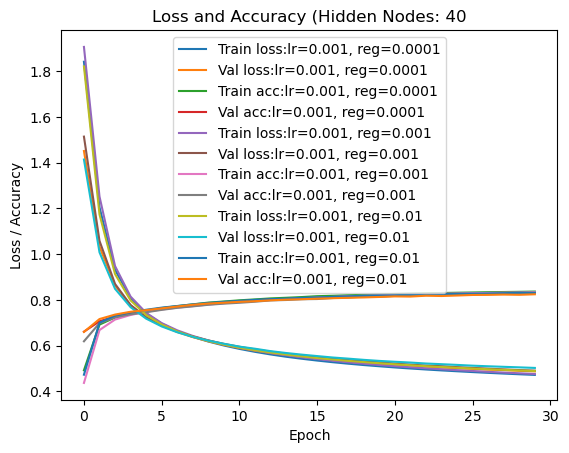

lr : 0.01
reg_val : 0.0001


Eval: 100%|███████████| 188/188 [00:01<00:00, 119.61batch/s, loss=0.467, acc=87]


reg_val : 0.001


Eval: 100%|█████████| 188/188 [00:01<00:00, 122.10batch/s, loss=0.429, acc=87.3]


reg_val : 0.01


Eval: 100%|███████████| 188/188 [00:01<00:00, 117.02batch/s, loss=0.493, acc=85]


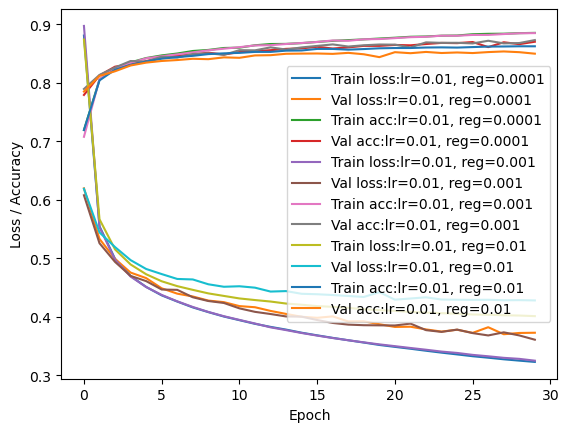

lr : 0.1
reg_val : 0.0001


Eval: 100%|█████████| 188/188 [00:01<00:00, 118.94batch/s, loss=0.497, acc=87.7]


reg_val : 0.001


Eval: 100%|█████████| 188/188 [00:01<00:00, 119.13batch/s, loss=0.343, acc=87.6]


reg_val : 0.01


Eval: 100%|███████████| 188/188 [00:01<00:00, 119.25batch/s, loss=0.5, acc=83.5]


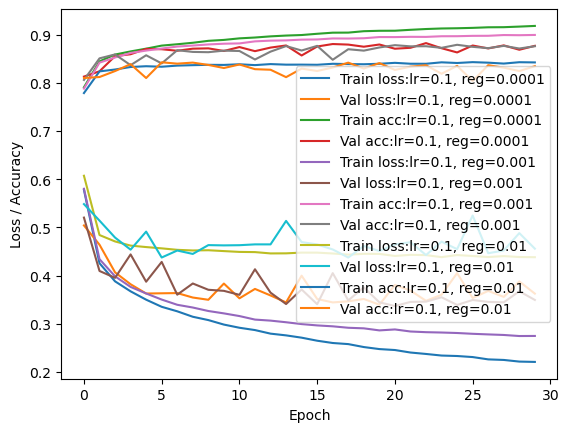

In [182]:
plot_learningcurve(40)

Hidden nodes: 80
lr : 0.001
reg_val : 0.0001
reg_val : 0.001
reg_val : 0.01


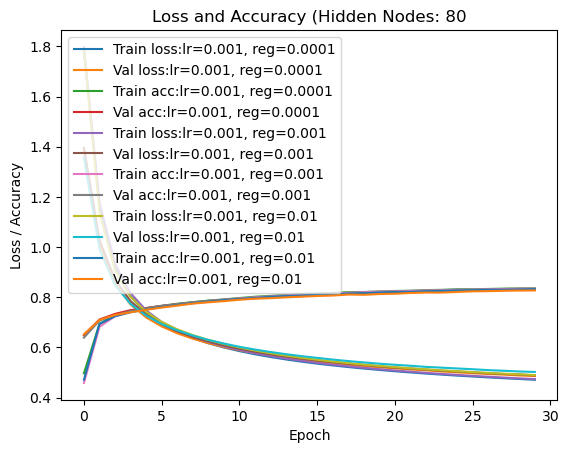

lr : 0.01
reg_val : 0.0001
reg_val : 0.001
reg_val : 0.01


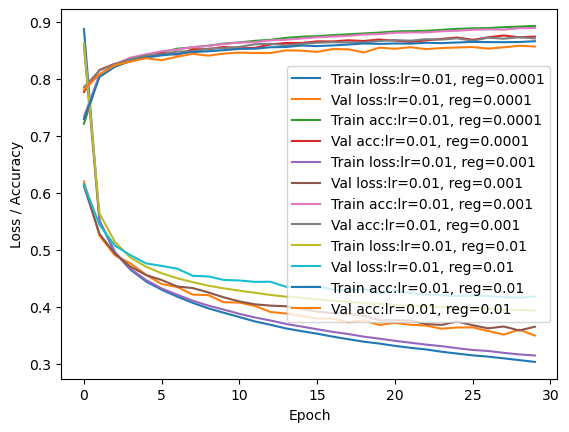

lr : 0.1
reg_val : 0.0001
reg_val : 0.001
reg_val : 0.01


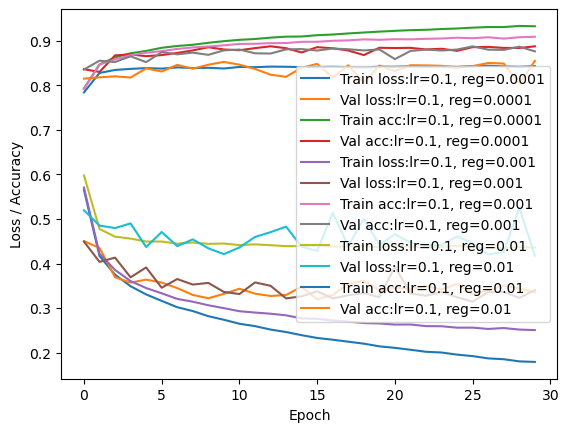

In [201]:
plot_learningcurve(80)

Hidden nodes: 160
lr : 0.001
reg_val : 0.0001
reg_val : 0.001
reg_val : 0.01


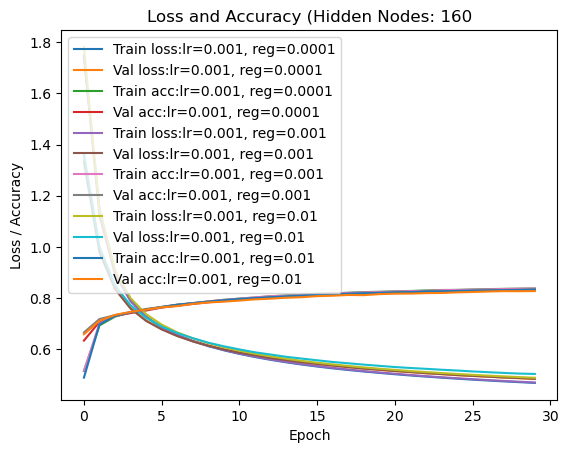

lr : 0.01
reg_val : 0.0001
reg_val : 0.001
reg_val : 0.01


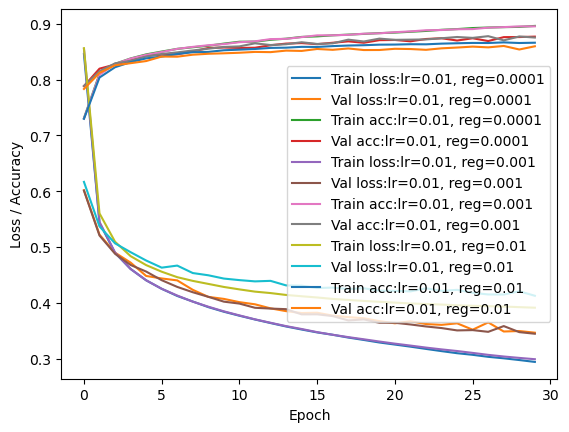

lr : 0.1
reg_val : 0.0001
reg_val : 0.001
reg_val : 0.01


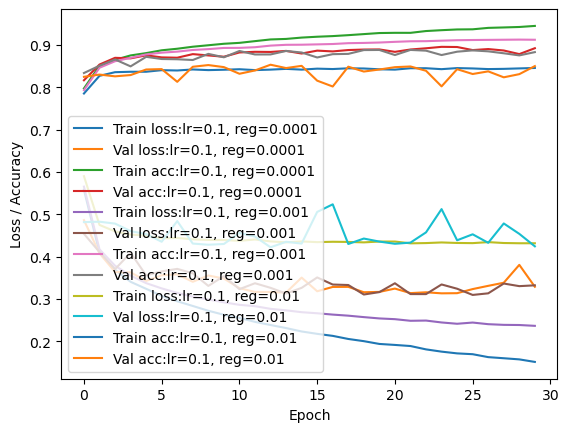

In [202]:
plot_learningcurve(160)

In [203]:
def use_best_hp(hidden, lr, reg_val):
    run = 0
    val_acc_list = []
    best_acc = -1
    for run in range(5):
        # Create a model
        model = MLP(hidden)
#                 lr = params['optimizer__lr'] 
#                 reg_val = params['optimizer__weight_decay'] 
        criterion = nn.CrossEntropyLoss() # includes softmax (for numerical stability)
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=reg_val)
        device = torch.device("cpu")
        model.to(device) # Move model to device
        
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
        valloader = torch.utils.data.DataLoader(valset, batch_size=batchsize, shuffle=False)
        
        epoch = 0
        highest_acc = -1
        
        for epoch in range(100):
            train_loss, train_acc  = train(model, trainloader, criterion, optimizer, device) # Train
            val_loss, val_acc = validate(model, valloader, criterion, device) # Validate
            
            if(val_acc > highest_acc):
                highest_acc = val_acc
        val_acc_list.append(highest_acc)
        
        if val_acc > best_acc: # Save best model
            best_acc = val_acc
            torch.save(model.state_dict(), "best_model.pt") # saving model parameters ("state_dict") saves memory and is faster than saving the entire model
    
    print('The best accuracy (over epochs) on val for each run is',val_acc_list)
    print('The mean, max, and std deviation for these 5 values is', np.mean(val_acc_list),max(val_acc_list),np.std(val_acc_list))
    
#     model.load_state_dict(torch.load("best_model.pt"))
#     testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize, shuffle=False)
    
#     test_loss, test_acc = validate(model, testloader, criterion, device)
#     print(f"Test accuracy: {test_acc:.4f}")

In [205]:
use_best_hp(160, 0.01, 0.001)

The best accuracy (over epochs) on val for each run is [0.8916666666666667, 0.8916666666666667, 0.8924166666666666, 0.8924166666666666, 0.8909166666666667, 0.8909166666666667, 0.8925, 0.8925, 0.8920833333333333, 0.8920833333333333]
The mean, max, and std deviation for these 5 values is 0.8919166666666667 0.8925 0.0005797509043641774


In [211]:
val_acc_list = [0.8916666666666667, 0.8924166666666666, 0.8909166666666667, 0.8925, 0.8920833333333333]
print('The best accuracy (over epochs) on val for each run is',val_acc_list)
print('The mean, max, and std deviation for these 5 values is', np.mean(val_acc_list),max(val_acc_list),np.std(val_acc_list))

The best accuracy (over epochs) on val for each run is [0.8916666666666667, 0.8924166666666666, 0.8909166666666667, 0.8925, 0.8920833333333333]
The mean, max, and std deviation for these 5 values is 0.8919166666666666 0.8925 0.0005797509043641774


In [209]:
def test():
    model = MLP(160)
    model.load_state_dict(torch.load("best_model.pt"))
    testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize, shuffle=False)
    
    test_loss, test_acc = validate(model, testloader, criterion, device)
    print(f"Test accuracy: {test_acc:.4f}")
test()

Test accuracy: 0.8838
